In [1]:
import pathlib
import itertools
from enum import StrEnum

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from swift_comet_pipeline.aperture.q_vs_aperture_radius_entry import (
    q_vs_aperture_radius_entry_list_from_dataframe,
)
from swift_comet_pipeline.lightcurve.lightcurve import dataframe_to_lightcurve, lightcurve_to_dataframe
from swift_comet_pipeline.lightcurve.lightcurve_aperture import (
    lightcurve_from_aperture_plateaus,
)
from swift_comet_pipeline.orbits.perihelion import find_perihelion
from swift_comet_pipeline.pipeline.files.pipeline_files import PipelineFiles
from swift_comet_pipeline.projects.configs import SwiftProjectConfig
from swift_comet_pipeline.stacking.stacking_method import StackingMethod
from swift_comet_pipeline.lightcurve.lightcurve import LightCurve
from swift_comet_pipeline.dust.reddening_correction import DustReddeningPercent
from swift_comet_pipeline.tui.tui_common import (
    clear_screen,
    get_selection,
    stacked_epoch_menu,
    wait_for_key,
)

In [2]:
def load_aperture_lightcurve(swift_project_config: SwiftProjectConfig) -> LightCurve:
    pipeline_files = PipelineFiles(swift_project_config.project_path)
    data_ingestion_files = pipeline_files.data_ingestion_files
    epoch_subpipeline_files = pipeline_files.epoch_subpipelines

    if data_ingestion_files.epochs is None:
        print("No epochs found!")
        return

    if epoch_subpipeline_files is None:
        print("No epochs available to stack!")
        return

    stacking_method = StackingMethod.summation

    t_perihelion_list = find_perihelion(data_ingestion_files=data_ingestion_files)
    if t_perihelion_list is None:
        print("Could not find time of perihelion!")
        return
    t_perihelion = t_perihelion_list[0].t_perihelion

    # aperture productions
    aperture_lc = lightcurve_from_aperture_plateaus(
        pipeline_files=pipeline_files,
        stacking_method=stacking_method,
        t_perihelion=t_perihelion,
    )

    if aperture_lc is None:
        return

    return aperture_lc

In [3]:
from swift_comet_pipeline.projects.configs import read_swift_project_config
# this folder has the pipeline calculating production for dust redness -100% through 100%
#wift_project_config_path = pathlib.Path("/Users/shawnoset/swift_analysis/C_2016R2/config.yaml")
swift_project_config_path = pathlib.Path("/Users/shawnoset/swift_analysis/C_2013US10_bayestest/config.yaml")
swift_project_config = read_swift_project_config(config_path=swift_project_config_path)

In [4]:
ap_lc = load_aperture_lightcurve(swift_project_config=swift_project_config)
ap_df = lightcurve_to_dataframe(lc=ap_lc)

In [5]:
def make_bayesian_prior_guess(mean_reddening: DustReddeningPercent, sigma_reddening: float):
    return norm(loc=float(mean_reddening), scale=sigma_reddening)

In [6]:
def lightcurve_from_apertures_bayesian(lc: LightCurve, mean_reddening: DustReddeningPercent, sigma_reddening: float) -> pd.DataFrame:
    lc_df = lightcurve_to_dataframe(lc=lc)
    
    # there may be multiple plateaus found for a given observation time and dust redness - which means multiple q(h2o).
    # this collapses the lightcurve into having just one q(h2o) per time/redness pair by averaging the plateau's q(h2o)s.
    averaged_lc_df = ap_df.groupby(['time_from_perihelion_days', 'dust_redness', 'rh_au', 'observation_time'])[['q']].mean().reset_index()
    
    # try to guess which dust rednesses the pipeline used in its analysis
    all_rednesses = sorted(averaged_lc_df.dust_redness.unique())

    # Entries for dust rednesses are missing if they came out to be a non-detection of water,
    # so fill in the rows with the missing redness value and a q(h2o) of zero
    filled_in_df_list = []
    for t_p, sub_df in averaged_lc_df.groupby(['time_from_perihelion_days']):
        temp_df = sub_df.set_index('dust_redness').reindex(all_rednesses).reset_index().copy()
        # missing dust rednesses came out to be a non-detection of production, so fill that in
        temp_df[['q']] = temp_df[['q']].fillna(0.0)
        # fill in the missing times by using the existing valid values: these should all be the same because we grouped by them
        temp_df[['time_from_perihelion_days']] = temp_df[['time_from_perihelion_days']].ffill().bfill()
        temp_df[['rh_au']] = temp_df[['rh_au']].ffill().bfill()
        temp_df[['observation_time']] = temp_df[['observation_time']].ffill().bfill()
        #print(temp_df)
        filled_in_df_list.append(temp_df)
    
    filled_in_df = pd.concat(filled_in_df_list)

    # make our dust redness prior
    f = make_bayesian_prior_guess(mean_reddening=mean_reddening, sigma_reddening=sigma_reddening)

    # fill in dataframe with prior probabilities
    filled_in_df['redness_prior_prob'] = filled_in_df['dust_redness'].map(lambda x: f.pdf(x))

    # calculate the water production times the probability that production is correct
    filled_in_df['posterior_qs'] = filled_in_df.q * filled_in_df.redness_prior_prob

    posterior_q_list = []
    non_detection_probs = []
    for t_p, sub_df in filled_in_df.groupby('time_from_perihelion_days'):
        non_zero_prod_mask = sub_df.q != 0.0
        posterior_q = np.sum(sub_df.posterior_qs[non_zero_prod_mask])
        posterior_q_list.append(posterior_q)
        non_detection_prob = np.sum(sub_df.redness_prior_prob[~non_zero_prod_mask])
        non_detection_probs.append(non_detection_prob)

    result_df = pd.DataFrame({'t_p': filled_in_df.time_from_perihelion_days.unique(), 'posterior_q': posterior_q_list, 'rh_au': filled_in_df.rh_au.unique(), 'observation_time': filled_in_df.observation_time.unique(), 'non_detection': non_detection_probs})

    # tag the heliocentric distance with plus or minus, negative distance being pre-perihelion
    result_df.rh_au = result_df.rh_au * np.sign(result_df.t_p)
    return result_df   

In [7]:
reduced_df = lightcurve_from_apertures_bayesian(lc=ap_lc, mean_reddening=45.0, sigma_reddening=2.5)
print(reduced_df[['rh_au', 'posterior_q', 'non_detection']])
#sns.pairplot(reduced_df, hue='observation_time')
#sns.regplot(data=reduced_df, x='rh_au', y='posterior_q')
#sns.lineplot(data=reduced_df, x='rh_au', y='posterior_q')
#sns.displot(data=reduced_df, x='rh_au', y='posterior_q', kind='kde')

       rh_au   posterior_q  non_detection
0  -5.828429  1.291306e+26   2.506509e-18
1  -5.030160  4.074611e+26   2.340344e-39
2  -4.574920  4.550128e+26   9.716756e-31
3  -3.158917  1.635616e+27   2.284545e-54
4  -2.521261  9.387040e+27  6.150271e-167
5  -1.832436  4.534566e+28  1.694243e-264
6  -1.558396  5.621402e+28  3.866190e-235
7   1.721369  1.252249e+28   0.000000e+00
8   2.146684  4.006253e+27  3.343320e-202
9   2.496119  1.463263e+27  1.337169e-126
10  4.021740  1.769864e+26   1.081906e-51
11  5.026661  1.846687e+25   7.935244e-02


In [8]:
reduced_df = lightcurve_from_apertures_bayesian(lc=ap_lc, mean_reddening=40.0, sigma_reddening=1.0)
print(reduced_df[['rh_au', 'posterior_q', 'non_detection']])
#sns.pairplot(reduced_df, hue='observation_time')
#sns.regplot(data=reduced_df, x='rh_au', y='posterior_q')
#sns.lineplot(data=reduced_df, x='rh_au', y='posterior_q')
#sns.displot(data=reduced_df, x='rh_au', y='non_detection', kind='kde', rug=True)

       rh_au   posterior_q  non_detection
0  -5.828429  1.085146e+26   7.004182e-64
1  -5.030160  3.724988e+26  2.277577e-171
2  -4.574920  3.768937e+26  3.342714e-126
3  -3.158917  1.487792e+27  3.790526e-252
4  -2.521261  9.032971e+27   0.000000e+00
5  -1.832436  4.465411e+28   0.000000e+00
6  -1.558396  5.516483e+28   0.000000e+00
7   1.721369  1.236588e+28   0.000000e+00
8   2.146684  3.868920e+27   0.000000e+00
9   2.496119  1.387611e+27   0.000000e+00
10  4.021740  1.633350e+26  1.341420e-237
11  5.026661  1.058583e+24   9.414419e-01


In [9]:
#lightcurve_from_apertures_bayesian(lc=ap_lc, mean_reddening=40.0, sigma_reddening=2.5)

In [10]:
#lightcurve_from_apertures_bayesian(lc=ap_lc, mean_reddening=40.0, sigma_reddening=5.0)

In [11]:
#lightcurve_from_apertures_bayesian(lc=ap_lc, mean_reddening=40.0, sigma_reddening=10.0)

In [12]:
#lightcurve_from_apertures_bayesian(lc=ap_lc, mean_reddening=40.0, sigma_reddening=20.0)

In [13]:
#lightcurve_from_apertures_bayesian(lc=ap_lc, mean_reddening=30.0, sigma_reddening=5.0)

In [14]:
#lightcurve_from_apertures_bayesian(lc=ap_lc, mean_reddening=30.0, sigma_reddening=10.0)

In [15]:
#lightcurve_from_apertures_bayesian(lc=ap_lc, mean_reddening=20.0, sigma_reddening=10.0)

In [16]:
#lightcurve_from_apertures_bayesian(lc=ap_lc, mean_reddening=20.0, sigma_reddening=5.0)

In [17]:
dust_means = np.linspace(15.0, 65.0, num=11, endpoint=True)
print(dust_means)
dust_sigmas = [1.0, 2.5, 5.0, 10.0]

total_df_dict = {}
for dust_mean, dust_sigma in itertools.product(dust_means, dust_sigmas):
    total_df_dict[dust_mean, dust_sigma] = lightcurve_from_apertures_bayesian(lc=ap_lc, mean_reddening=dust_mean, sigma_reddening=dust_sigma)

[15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65.]


In [18]:
total_df = pd.concat(total_df_dict, axis=0).reset_index()
total_df = total_df.drop(columns=['level_2'])
total_df = total_df.rename(columns={'level_0': 'dust_mean', 'level_1': 'dust_sigma'})
print(total_df.dust_mean.unique())
total_df

[15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65.]


,dust_mean,dust_sigma,t_p,posterior_q,rh_au,observation_time,non_detection
0,15.0,1.0,-458.494843,7.496409e+07,-5.828429,2014-08-14 16:59:10.088235,1.000000e+00
1,15.0,1.0,-375.563810,1.352026e+26,-5.030160,2014-11-05 15:19:51.281249,4.567171e-03
2,15.0,1.0,-330.545061,3.059015e+24,-4.574920,2014-12-20 15:46:51.187500,9.414419e-01
3,15.0,1.0,-201.653077,6.173270e+26,-3.158917,2015-04-28 13:11:18.611110,1.028054e-18
4,15.0,1.0,-149.256644,7.554478e+27,-2.521261,2015-06-19 22:42:10.500000,0.000000e+00
...,...,...,...,...,...,...,...
523,65.0,10.0,86.972724,1.302171e+28,1.721369,2016-02-11 04:12:26.815789,0.000000e+00
524,65.0,10.0,119.083720,4.464992e+27,2.146684,2016-03-14 06:52:16.928571,6.242004e-22
525,65.0,10.0,146.327158,1.625796e+27,2.496119,2016-04-10 12:42:49.968750,9.080536e-16
526,65.0,10.0,277.256061,2.207034e+26,4.021740,2016-08-19 11:00:27.185185,4.399491e-09


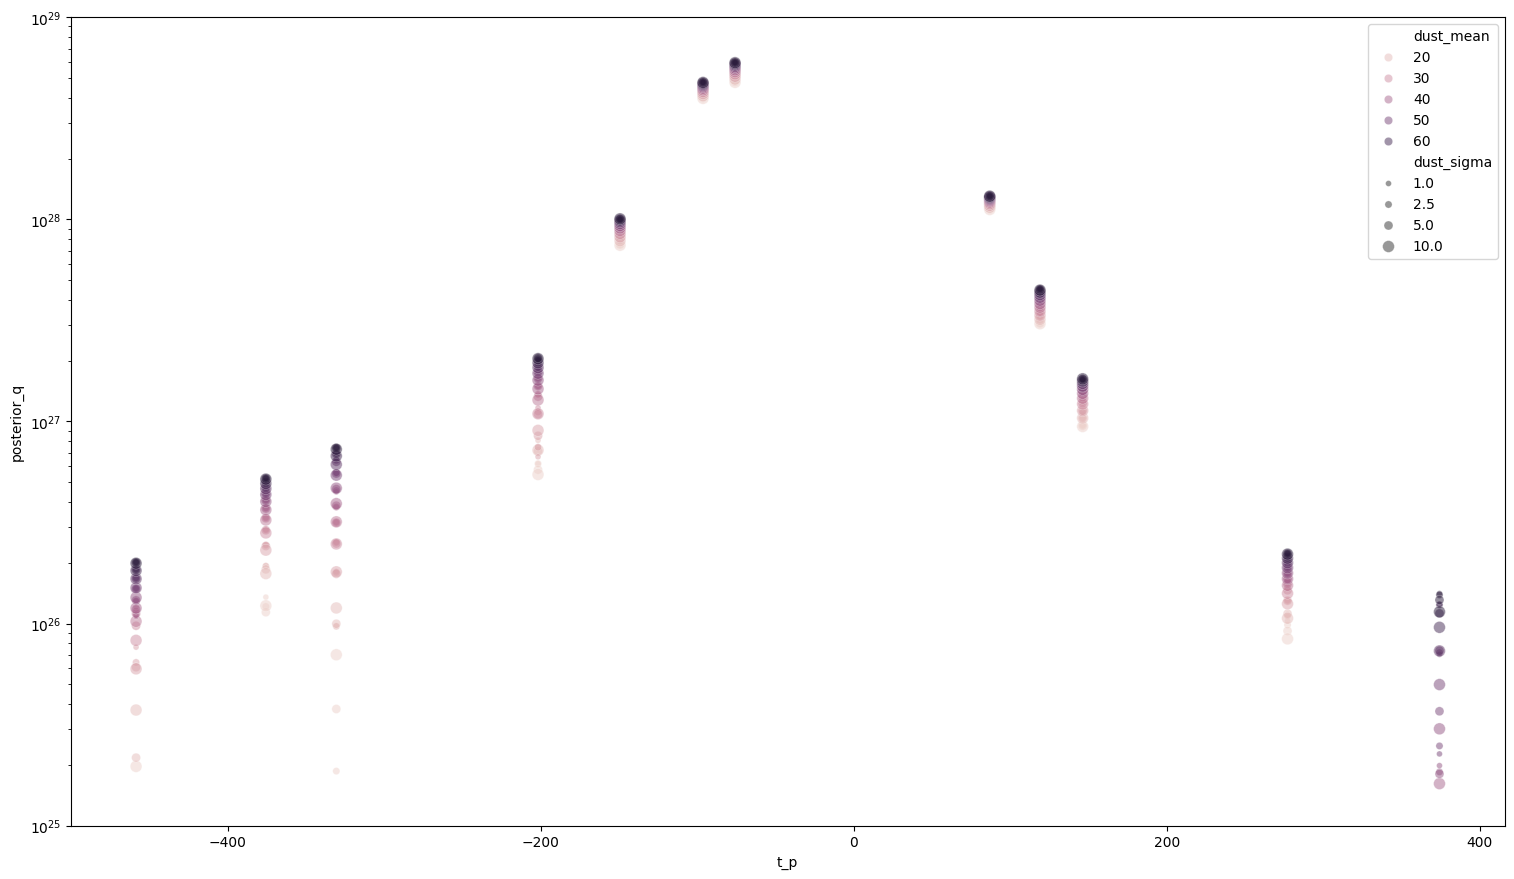

In [19]:
#sns.scatterplot(data=total_df, x='rh_au', y='posterior_q', hue='dust_mean', style='dust_sigma')
sns.scatterplot(data=total_df, x='t_p', y='posterior_q', hue='dust_mean', size='dust_sigma', alpha=0.5)
plt.yscale('log')
plt.ylim(1.0e25, 1.0e29)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

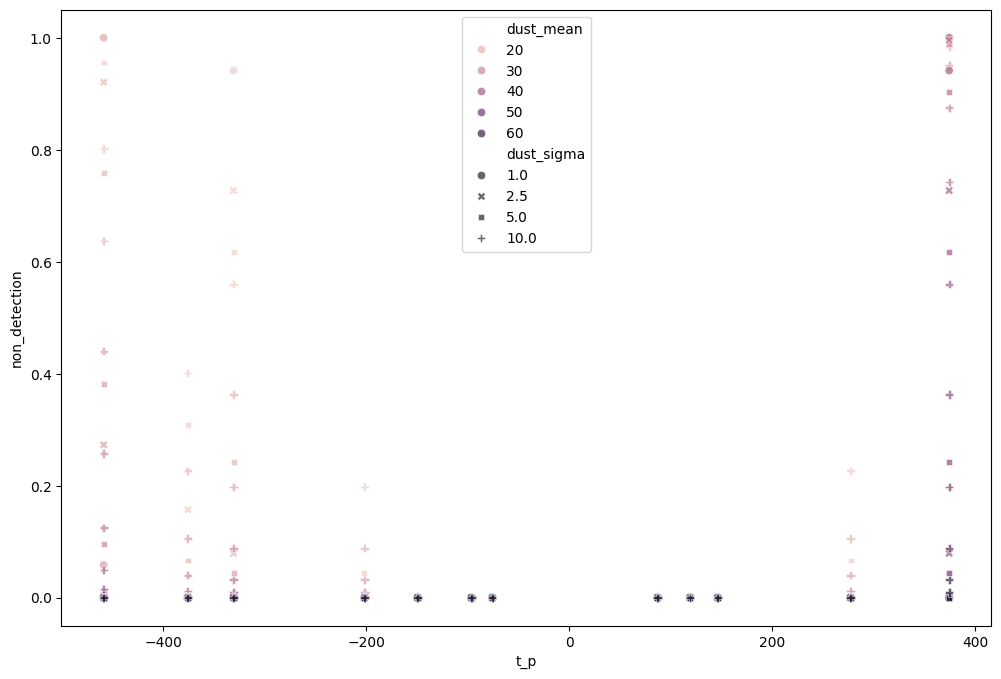

In [20]:
sns.scatterplot(data=total_df, x='t_p', y='non_detection', hue='dust_mean', style='dust_sigma', alpha=0.75)
fig = plt.gcf()
fig.set_size_inches(12, 8)

In [21]:
#sns.pairplot(total_df, hue='dust_mean')

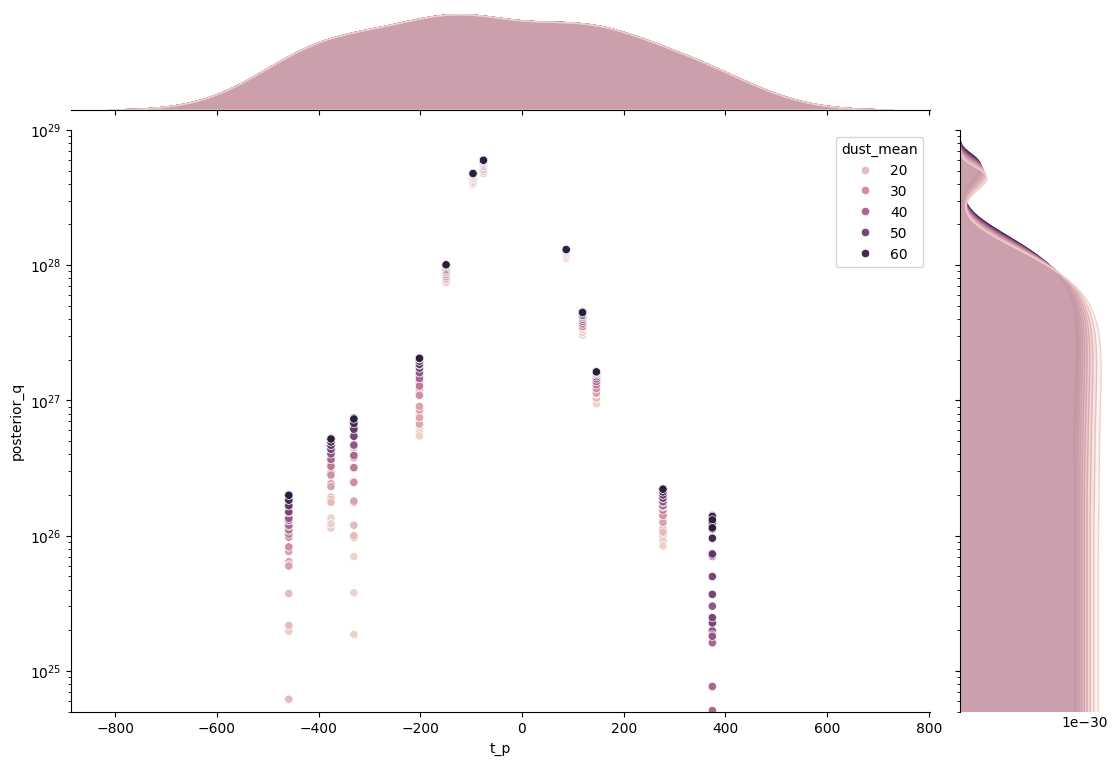

In [22]:
sns.jointplot(data=total_df, x='t_p', y='posterior_q', hue='dust_mean')
plt.yscale('log')
plt.ylim(5.0e24, 1.0e29)
fig = plt.gcf()
fig.set_size_inches(12, 8)

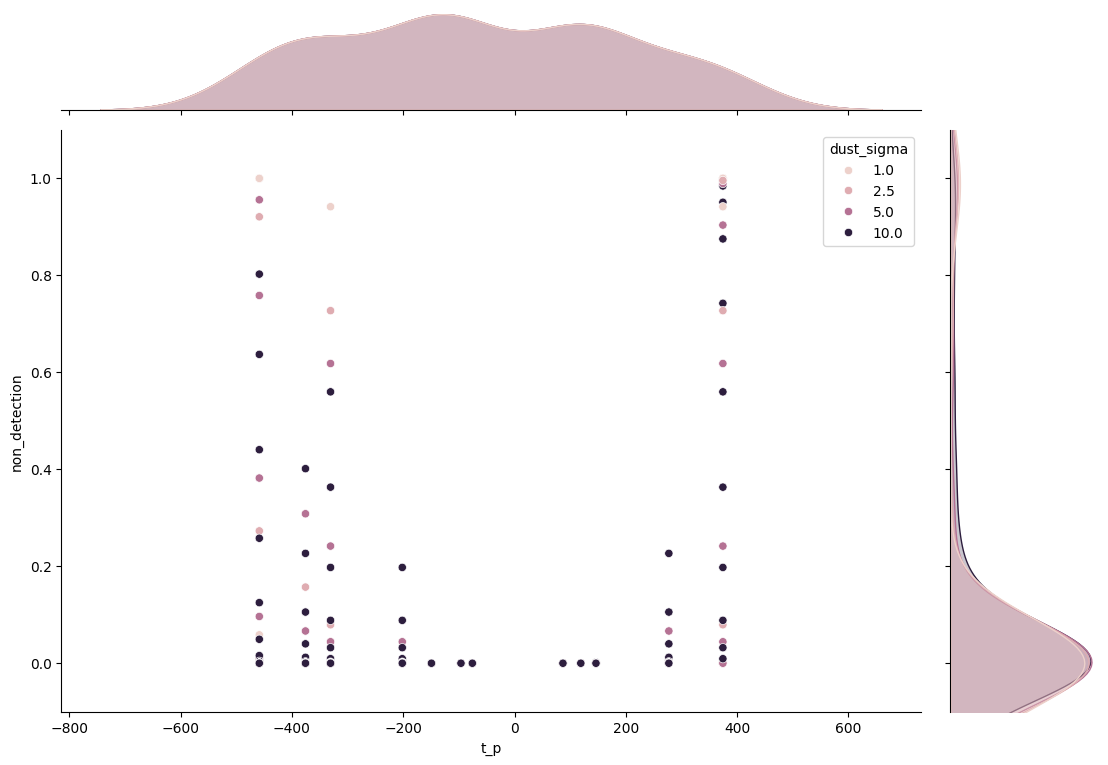

In [23]:
sns.jointplot(data=total_df, x='t_p', y='non_detection', hue='dust_sigma')
plt.ylim(-0.1, 1.1)
fig = plt.gcf()
fig.set_size_inches(12, 8)

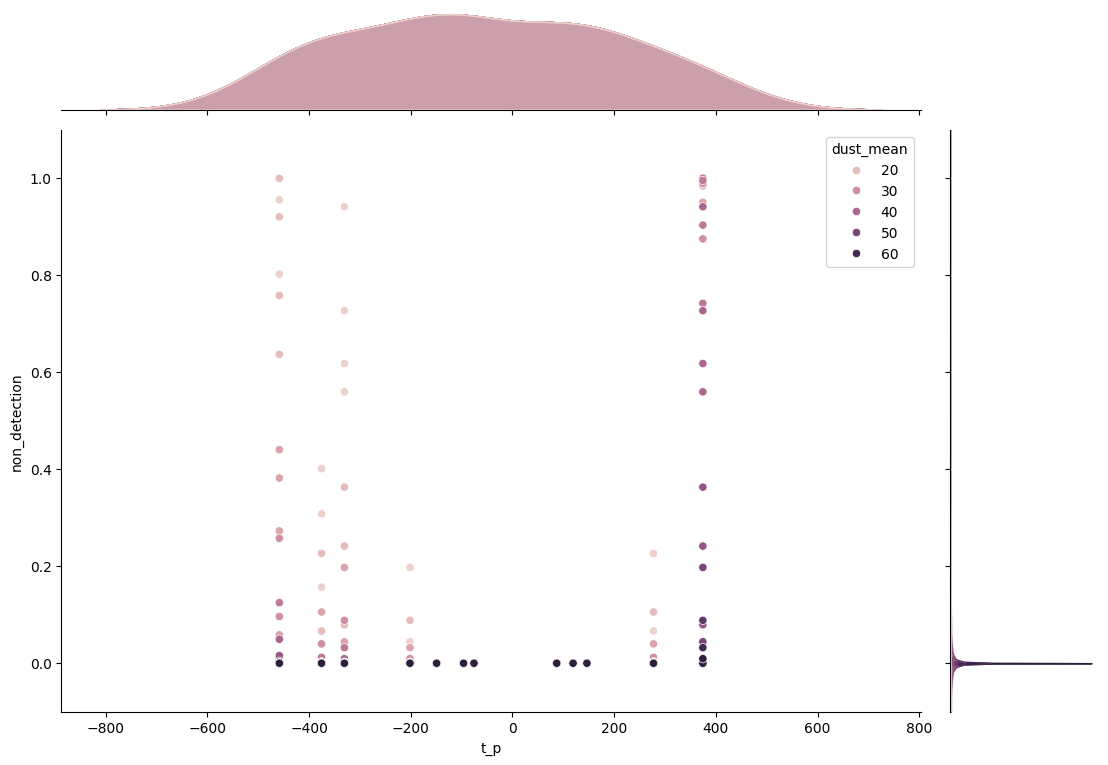

In [24]:
sns.jointplot(data=total_df, x='t_p', y='non_detection', hue='dust_mean')
plt.ylim(-0.1, 1.1)
fig = plt.gcf()
fig.set_size_inches(12, 8)

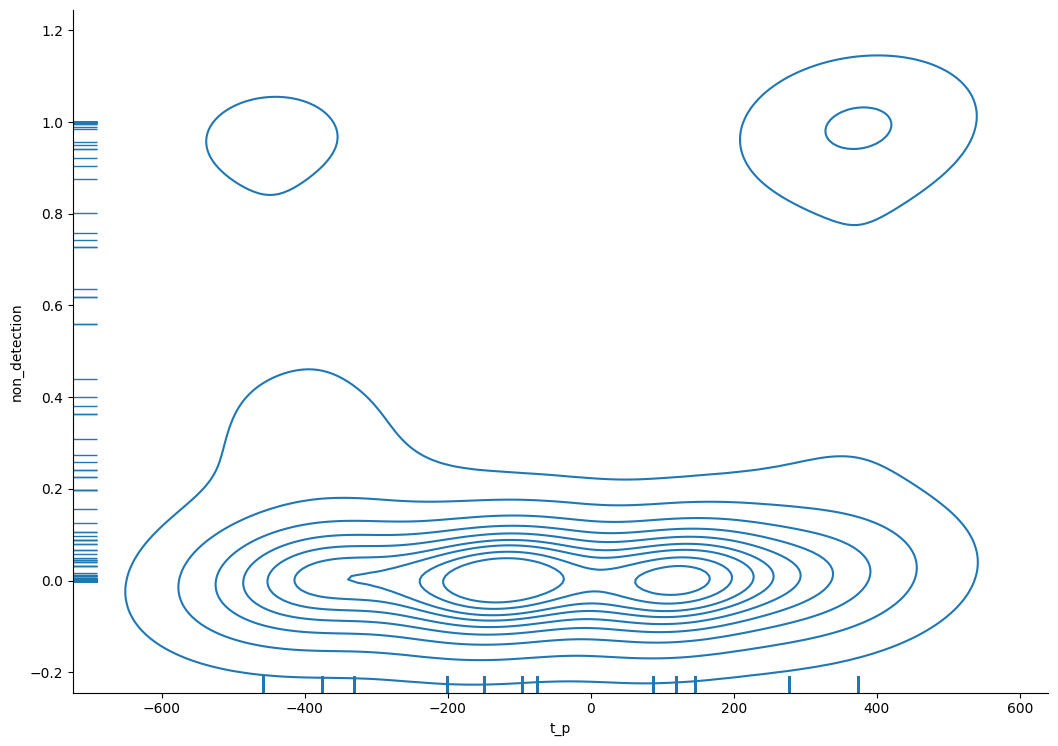

In [25]:
sns.displot(data=total_df, x='t_p', y='non_detection', kind='kde', rug=True)
fig = plt.gcf()
fig.set_size_inches(12, 8)

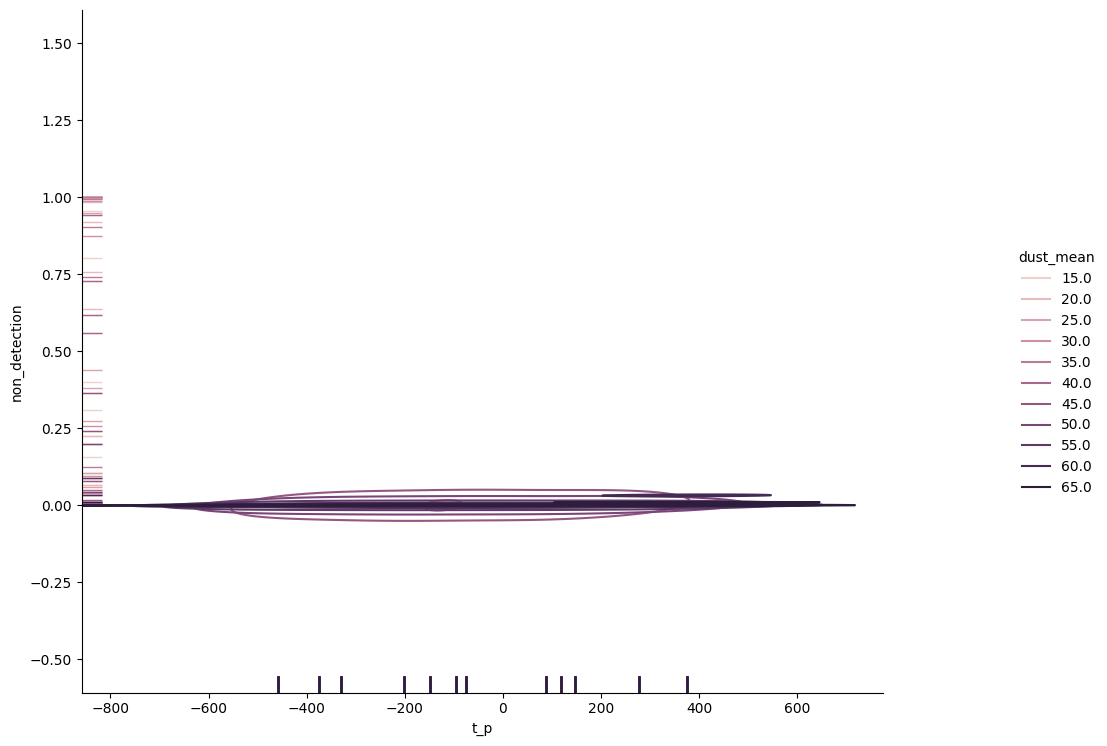

In [26]:
sns.displot(data=total_df, x='t_p', y='non_detection', kind='kde', rug=True, hue='dust_mean')
fig = plt.gcf()
fig.set_size_inches(12, 8)

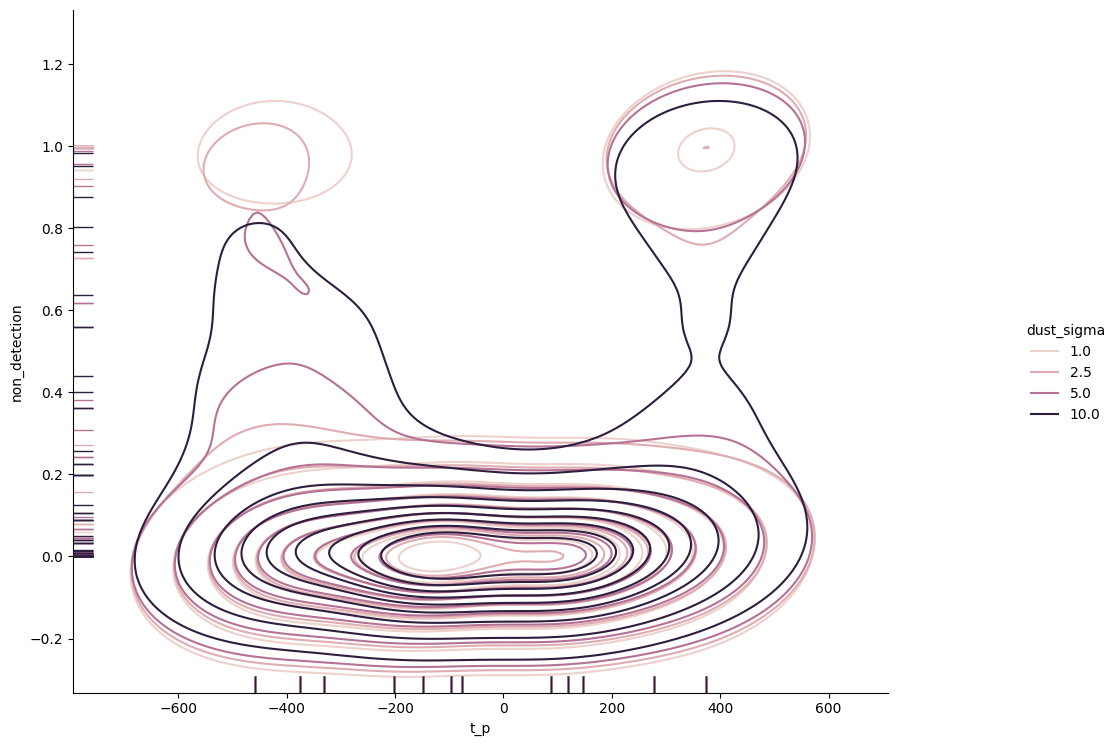

In [27]:
sns.displot(data=total_df, x='t_p', y='non_detection', kind='kde', rug=True, hue='dust_sigma')
fig = plt.gcf()
fig.set_size_inches(12, 8)

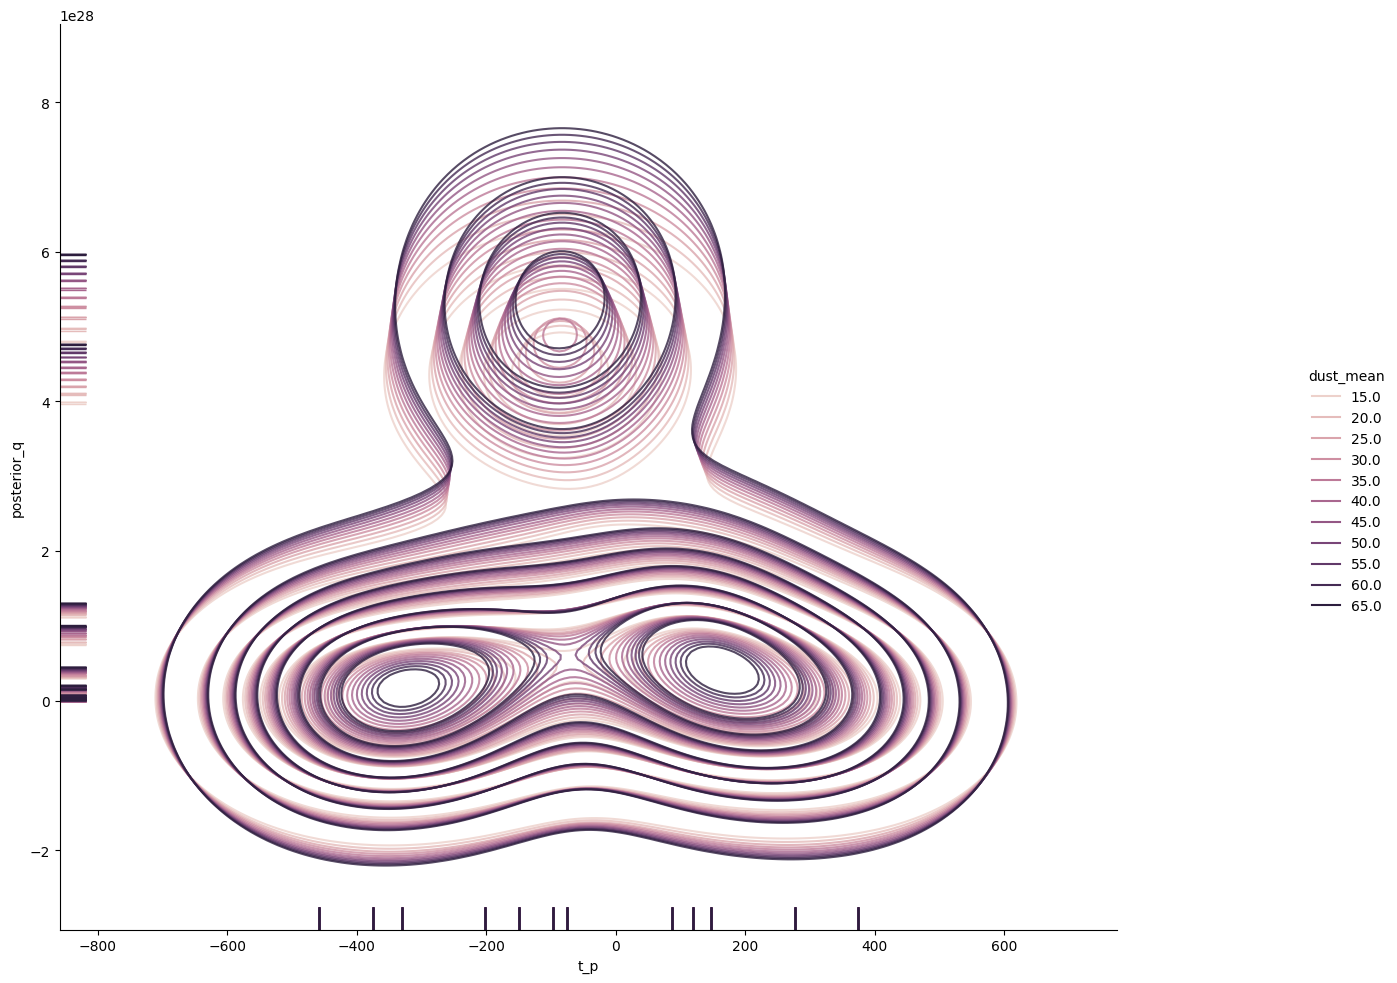

In [28]:
sns.displot(data=total_df, x='t_p', y='posterior_q', kind='kde', rug=True, hue='dust_mean', alpha=0.8)
fig = plt.gcf()
fig.set_size_inches(15, 11)
#plt.yscale('log')
#plt.ylim(1.0e23, 1.0e29)

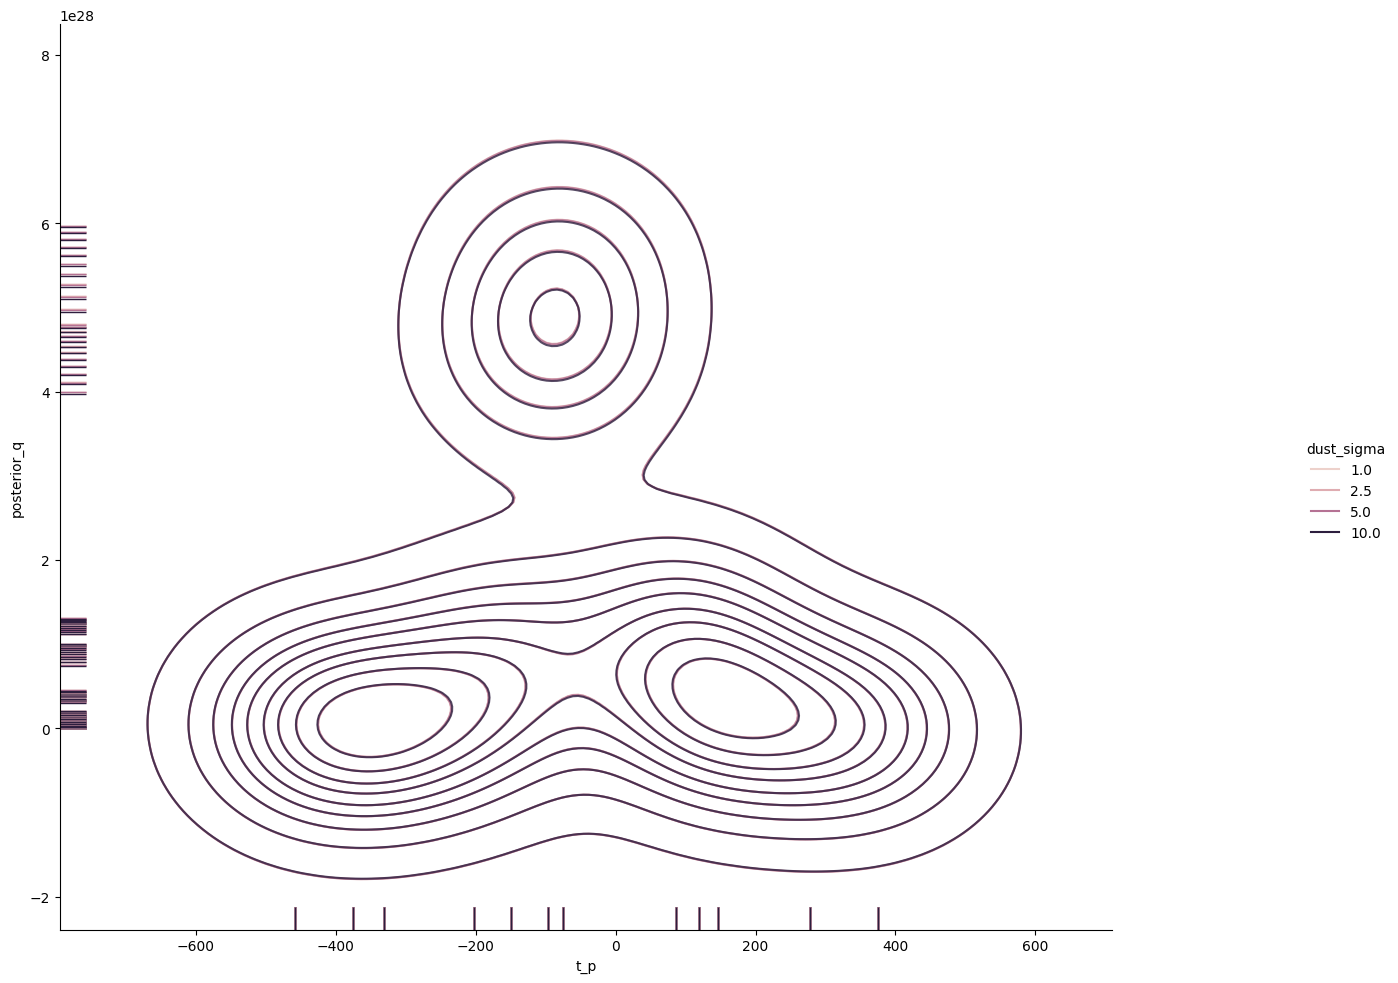

In [29]:
sns.displot(data=total_df, x='t_p', y='posterior_q', kind='kde', rug=True, alpha=0.8, hue='dust_sigma')
fig = plt.gcf()
fig.set_size_inches(15, 11)
#plt.yscale('log')
#plt.ylim(1.0e23, 1.0e29)

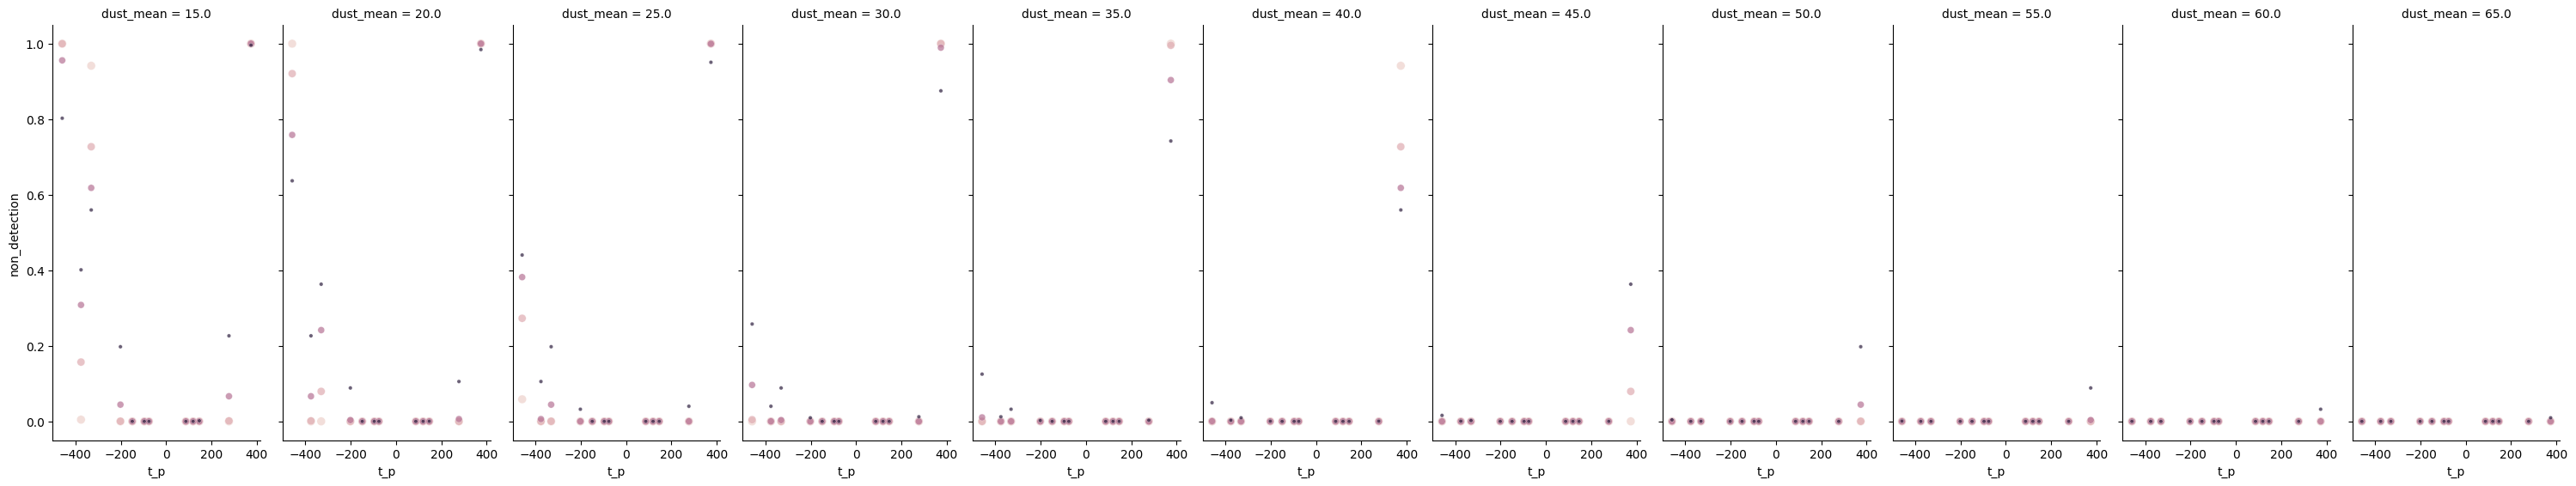

In [30]:
g = sns.FacetGrid(total_df, col="dust_mean")
g.map_dataframe(sns.scatterplot, data=total_df, x='t_p', y='non_detection', hue='dust_sigma', size='dust_sigma', sizes=(50, 10), alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(30, 7)

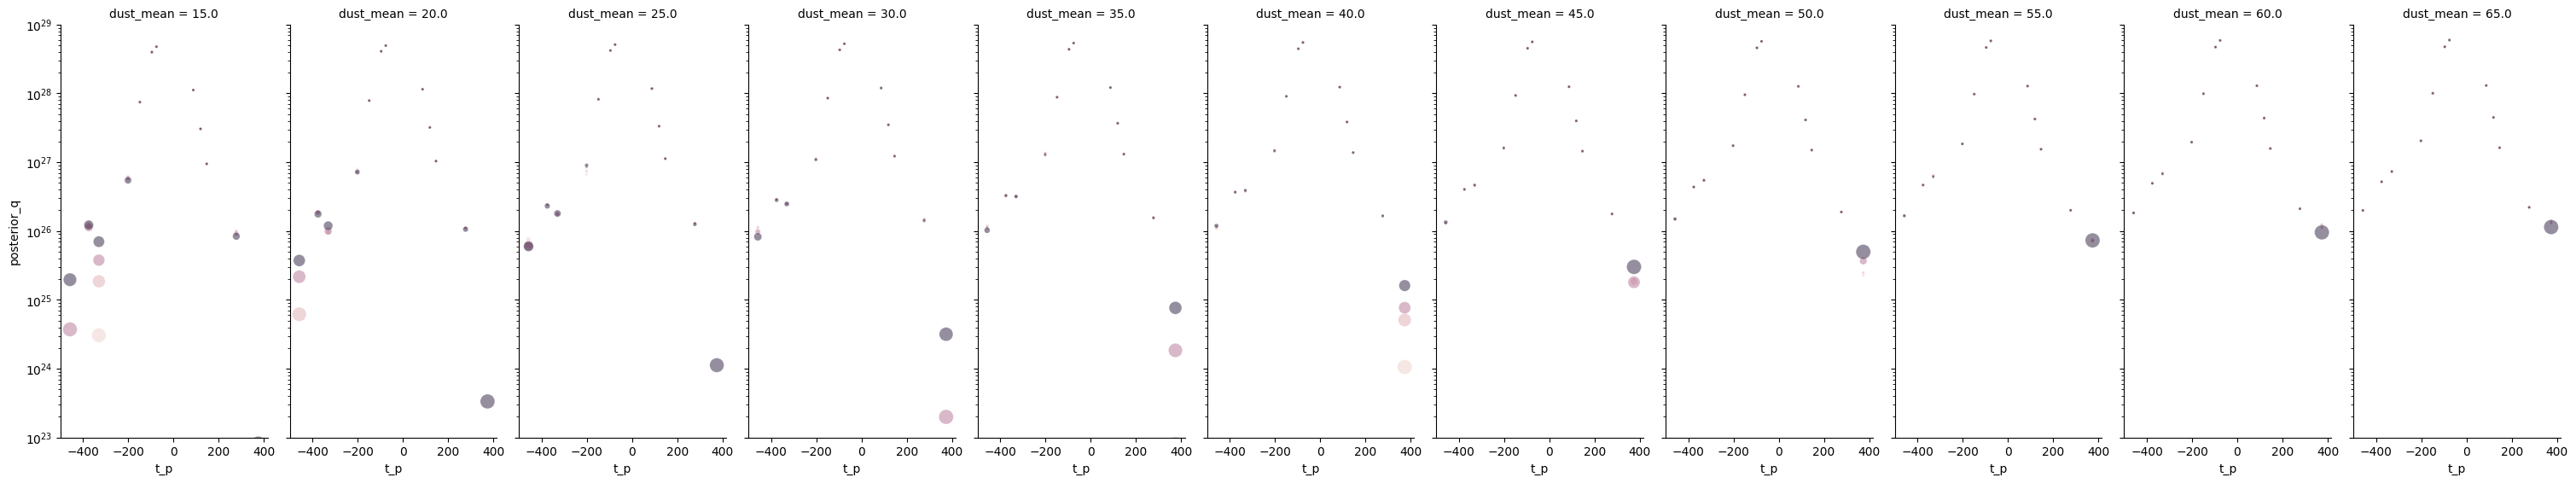

In [31]:
g = sns.FacetGrid(total_df, col="dust_mean")
g.map_dataframe(sns.scatterplot, data=total_df, x='t_p', y='posterior_q', hue='dust_sigma', size='non_detection', sizes=(5, 150), alpha=0.5)
#g.map_dataframe(sns.scatterplot, data=total_df, x='t_p', y='posterior_q', hue='dust_sigma', size='non_detection', sizes=(50, 10), alpha=0.7)
plt.yscale('log')
plt.ylim(1.0e23, 1.0e29)
fig = plt.gcf()
fig.set_size_inches(30, 7)

In [32]:
# sns.scatterplot(data=total_df, x='t_p', y='posterior_q', hue='dust_mean', size='dust_sigma', alpha=0.5)
# ax2 = plt.twinx()
# sns.scatterplot(data=total_df, x='t_p', y='non_detection', hue='dust_mean', size='dust_sigma', ax=ax2)
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)

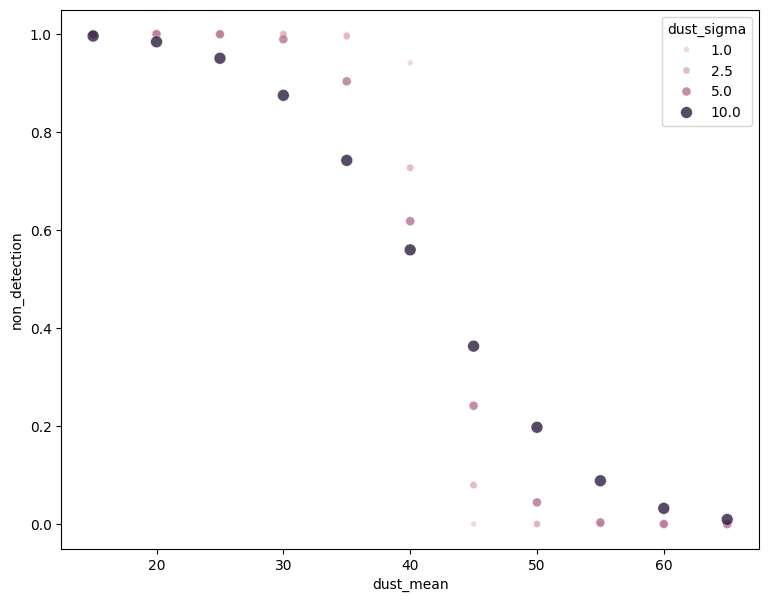

In [49]:
# what does the last observation's non-detection probability look like as a function of mean dust redness?
m = total_df.t_p == total_df.t_p.unique()[-1]
sns.scatterplot(data=total_df[m], x='dust_mean', y='non_detection', size='dust_sigma', hue='dust_sigma', alpha=0.8)
fig = plt.gcf()
fig.set_size_inches(9, 7)